In [13]:
#Define showcode button action
from IPython.display import HTML
showcode='''
<style>
.button {
    background-color: #e7e7e7;
    color: black; /* Green */
    border: none;
    padding: 5px;
    text-align: center;
    text-decoration: none;
    display: inline-block;
    font-size: 10px;
    margin: 2px 2px;
    cursor: pointer;
}
.button5 {border-radius: 50%;}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code" class="button button5"></form>

'''

# Modeling Extreme Events

In [14]:
HTML(showcode)

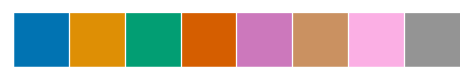

In [87]:
#Import stuff
%matplotlib inline
import base64
from collections import namedtuple, OrderedDict
from datetime import datetime
import glob
import io
import os
import sys
os.environ['PROJ_LIB']=os.path.join(os.environ['HOME'],'.anaconda3','share','proj')




from astropy.stats import LombScargle
import astropy.units as u
from brewer2mpl import qualitative
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
import h5py
from IPython.display import HTML
import matplotlib as mpl
from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, cm as colmap
import mpld3
from netCDF4 import Dataset as nc, num2date, MFDataset as mc, date2num
import numpy as np
import palettable as colortable
from palettable.mycarta import LinearL_20, CubeYF_20
from palettable.colorbrewer.qualitative import Paired_12
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import pytz
import seaborn as sns
from scipy import signal
import tempfile
import xarray as xr

from DataFrame import *
from tint.visualization import make_mp4_from_frames, plot_traj

sns.set()
fontsize = 30
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : fontsize}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = [15.0,10.0]
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'
plt.style.use("seaborn-talk")

pal = sns.palplot(sns.color_palette("colorblind", 8))
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
sns.set_context('talk')
sns.set_palette(pal)
sns.despine()
np.warnings.filterwarnings('ignore')
utc = pytz.UTC
timezone = pytz.timezone('Australia/Darwin')
pal

In [16]:
# Define the paths
CPOLF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_TIWI_1998-2017-old.nc')
WOHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOH.nc')
CMORPHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'UM', 'CMORPH_V1_WOH.nc')
WOHFv1 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv1.nc')
WOHFv2 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv2.nc')
BurstF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_burst-cmorph.pkl')
PercF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_Percentiles-old.hdf5')
extremeTS = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_TS_extrme.pkl')
percf =  os.path.join(os.environ['HOME'],'Data','Extremes','CPOL', 'Periods.npz')
outdir = os.path.join(os.getenv('HOME'),'Data','Extremes','UM', 'Plot', 'Week_of_Hector')
geodataf = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
remap_res = '2.5km'

The study domain and the model domain setup

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
topocmap = plt.cm.gist_earth
topocmap.set_bad('w', alpha=0)
#First the greater area map
with nc(os.path.join(geodataf,'topo_2.nc')) as topof:
    Gtopo=np.ma.masked_equal(topof.variables['topo'][:],0)
    Gtopolon=topof.variables['longitude'][:]
    Gtopolat=topof.variables['latitude'][:]
#Now only the tiwi-islands manp
with nc(os.path.join(geodataf,'Topo.nc')) as topof:
    topo=np.ma.masked_equal(topof.variables['topo'][:],0)
    topolon=topof.variables['longitude'][:]
    topolat=topof.variables['latitude'][:]
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
ls = LightSource(azdeg=315, altdeg=45)
#tmap.pcolormesh(topolon, topolat, ls.hillshade(topo[:], vert_exag=1), cmap= topocmap)

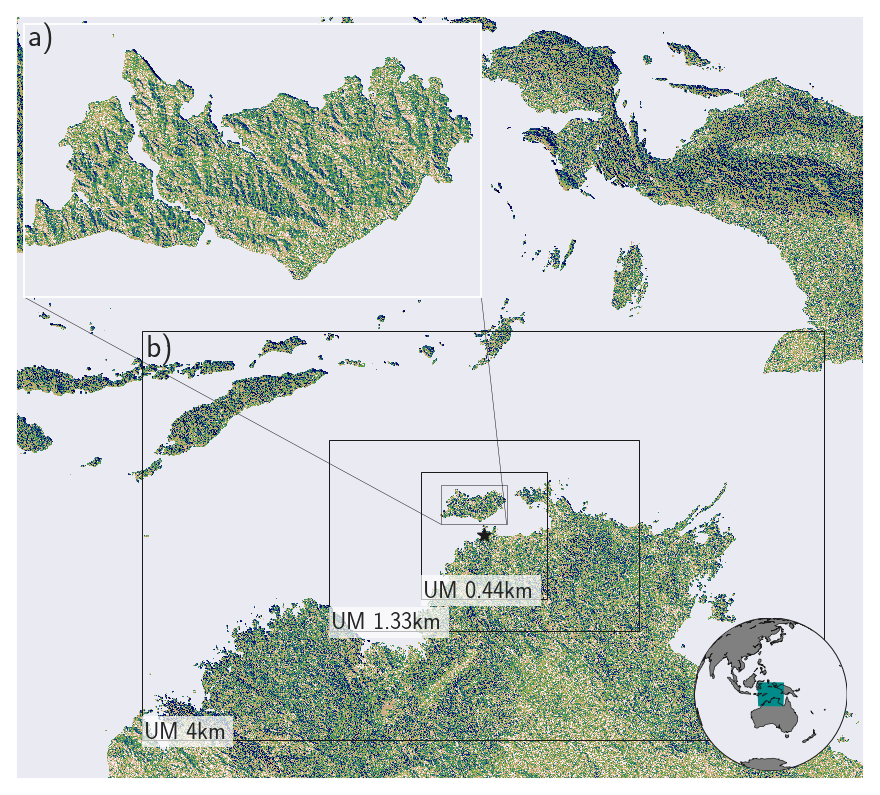

In [6]:
#
fontsize_tmp = fontsize
fontsize=20
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
topocmap = plt.cm.gist_earth
topocmap.set_bad('w', alpha=0)
#First the greater area map
with nc(os.path.join(geodataf,'topo_2.nc')) as topof:
    Gtopo=np.ma.masked_equal(topof.variables['topo'][:],0)
    Gtopolon=topof.variables['longitude'][:]
    Gtopolat=topof.variables['latitude'][:]
#Now only the tiwi-islands manp
with nc(os.path.join(geodataf,'Topo.nc')) as topof:
    topo=np.ma.masked_equal(topof.variables['topo'][:],0)
    topolon=topof.variables['longitude'][:]
    topolat=topof.variables['latitude'][:]
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ls = LightSource(azdeg=315, altdeg=45)

M = Basemap(projection='rotpole', llcrnrlat=min(Gtopolat), llcrnrlon=min(Gtopolon), urcrnrlat=max(Gtopolat), urcrnrlon=max(Gtopolon), 
            resolution='c', area_thresh=1, ax=ax, lon_0=0, o_lon_p=0., o_lat_p=90.,)
borders = (([122.963, 139.055], [-17.091, -7.443]), 
           ([127.385, 134.693], [-14.505, -10.005]), 
           ([129.557, 132.529], [-13.757, -10.757]))
text=(('UM 4km', fontsize+4), ('UM 1.33km', fontsize+4), ('UM 0.44km', fontsize+4))
M.pcolormesh(Gtopolon, Gtopolat, ls.hillshade(Gtopo[:], vert_exag=1), cmap= topocmap, ax=ax)
#M.drawmapscale(M.boundarylons[0]-0.7, M.boundarylats[0]+0.7, max(topolon), min(topolat), 10, 
#              barstyle='fancy', fontsize=19, labelstyle='simple')
for conf in range(3):
    lons,lats = borders[conf]
    txt, fts = text[conf]
    x, y = M([lons[0], lons[0], lons[1],lons[1]], [lats[0], lats[1], lats[1], lats[0]])
    xy = list(zip(x,y))
    ttt = plt.text(*M(lons[0]+0.1, lats[0]+0.05), txt, fontsize=fts)
    ttt.set_bbox(dict(facecolor='w', alpha=0.7, edgecolor='none', lw=1))
    poly = Polygon(xy, alpha=1, edgecolor='k', lw=1, facecolor='none')
    plt.gca().add_patch(poly)
#M.drawcoastlines()
M.scatter(*M(131.043101, -12.250323), marker='*',color='k', s=200)
plt.text(*M(borders[0][0][0]+0.15, borders[0][-1][1]-0.6), 'b)', fontsize=fontsize+12)
axins = zoomed_inset_axes(ax, 7, loc=2)
axins.set_xlim(min(topolon), max(topolon))
axins.set_ylim(min(topolat), max(topolat))
tmap = Basemap(projection='cyl',llcrnrlat=min(lat), llcrnrlon=min(lon), urcrnrlat=max(lat), urcrnrlon=max(lon), 
               resolution='c',  area_thresh=1, ax=axins)
tmap.pcolormesh(topolon, topolat, ls.hillshade(topo[:], vert_exag=1), cmap= topocmap)
mark_inset(ax, axins, loc1=3, loc2=4, fc="k", ec='k', lw=0.5)
plt.annotate('a)', xy=(0.01 ,0.92), xycoords='axes fraction', fontsize=fontsize+12)
lons, lats = [min(Gtopolon), max(Gtopolon)], [min(Gtopolat), max(Gtopolat)]
axins2 = inset_axes(ax, width='20%', height='20%', loc=4)
Worldmap= Basemap(projection='ortho', lat_0=Gtopolat[int(len(Gtopolat)/2)], lon_0=Gtopolon[int(len(Gtopolon)/2)],
                 ax=axins2)
Worldmap.drawcoastlines(color='k', linewidth=0.7)
Worldmap.fillcontinents(color='gray')
bx, by = Worldmap(M.boundarylons, M.boundarylats)
xy = list(zip(bx,by))
poly = Polygon(xy, alpha=1, edgecolor='none', lw=0, facecolor='darkcyan')
_ = Worldmap.ax.add_patch(poly)
_ = fig.subplots_adjust(bottom=0.35)
_ = fig.savefig('Vid/Topo.png', bbox_inches='tight', format='png', dpi=300)
fontsize = fontsize_tmp

# 2.0 Climatology of rainfall and the importance of the diurnal cycle
To investigate the links between Monsoon stage and Rainfall extremes in the considered area it is worthwhile having a look at the general climatology of rainfall and investigate the importance of the diurnal cycle in the stduy domain. 

The relative importance of the diurnal cycle is investigated in two ways:
* Calculating the fraction of total variability each frequency for the spectral density of the domain avg. rain-rates
* Presenting a map the fraction of variability for the 1/24h frequncy band of the spectral density at each grid-point
* Presenting the diurnal cycle



In [92]:
nplot = 1
# First get the domain avg rain-rates, the domain co-ordinates and the time-vector for the cpol era
outfile =  os.path.join(os.path.dirname(CPOLF),'rainfall_TS.hdf')
create = True
with nc(CPOLF) as fnc:
    mask = fnc.variables['mask'][:]
    if not os.path.isfile(outfile) or create:
        rr = fnc.variables['lsrain'][:] * mask
        times = num2date(fnc.variables['t'][:], fnc.variables['t'].units)
        T = date2num(times, times[0].strftime('Days since %Y-%m-%d %H:%M:%S'))
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
if not os.path.isfile(outfile):   
    rr_aavg = pd.Series(np.nanmean(rr, axis=(1,2)), index=times)
else:
    rr_aavg = pd.read_hdf(outfile,'rr')
    times = rr_aavg.index
cpol = xr.open_dataset(CPOLF)
ispres10min = pd.Series(cpol.variables['ispresent'].values, index=times)
dates = ispres10min.index.date
ispres24h = ispres10min.groupby(pd.TimeGrouper('d')).sum()
thresh = ispres24h.loc[ispres24h > 0.75 * 144].index
threshidx = np.array([i for i, date in enumerate(ispres10min.index.date) if date in thresh])

In [93]:
cpol24h = cpol.variables['lsrain'][threshidx].values.reshape(-1,len(thresh), cpol.coords['latitude'].shape[0],
                                                      cpol.coords['longitude'].shape[0])
cpol24h = np.nanmean(cpol24h, axis=0)

#### Calculate the fraction of total spectral variance
Because the cpol data contains holes (missing data) we chose to create a Lomb-Scargle periodigram rather than a 
a fourier decomposition of the data. Lomb-Scargle periodigrams are created by least-spaure fitting sinosoids to the data. The LombScargle Class provided by astropy's stats module will create the periodogram. For best practice we create a function that calculates the fraction of the spectral variance.

In [96]:
#Define the function that calculates spec variances
def get_psd(data, t, freq=1):
    '''Calculate the fraction of power for each freq in the spectrum of a given TS
       data = the time-series
       freq = return only the fraction for a given freq. band
       step = sample freq in minutes
    '''
    f, power = LombScargle(t, data, 1).autopower(minimum_frequency=0.01667, maximum_frequency=3.5, method='fast')
    if freq is None:
        return 1/f, power/power.sum() * 100
    else:
        nn = np.argmin(np.fabs(1/f-freq))
        return power[nn-2:nn+2].sum()/power.sum() * 100

Calculate the psd for the area total avg rain-rates first

In [95]:
#Calculate the area avg % of spectral variances
rr_aavg = rr_aavg.loc[rr_aavg>0]
idx = date2num(rr_aavg.dropna().index.to_pydatetime(), 'days since 1970-01-01 00:00:00')
f, psd = get_psd(rr_aavg.dropna().values, idx, freq=None)
idx = (f < 0.6) & (psd*9>0.04)
psd[idx] /= 100.

Now calculate the map of spectral variance in the diurnal cycle

In [97]:
#Calculate the field of perc. of spectral variance for 24 h
spec_map = np.zeros([len(lat), len(lon)]) * mask
create = False
if not os.path.isfile(percf) or create:
    for i in range(len(lat)):
        for j in range(len(lon)):
            if not spec_map.mask[i,j]:
                sys.stdout.flush()
                sys.stdout.write('\r Calculating TS for : %0.2f, %0.2f'%(lat[i],lon[j]))
                sys.stdout.flush()
                rr_tmp = pd.Series(rr[:,i,j].filled(np.nan), index=T).dropna()
                rr_tmp = rr_tmp.loc[rr_tmp>0]
                spec_map[i,j] = get_psd(rr_tmp.values, rr_tmp.index, freq=1)
        
    np.savez_compressed(percf, perc=spec_map.filled(-99))
else:
    print()
    spec_map = np.ma.masked_less(np.load(percf)['perc'], 0)
sys.stdout.write('\n')

In [98]:
#Create the CPOL map
m = Basemap(llcrnrlat=min(lat), llcrnrlon=min(lon), urcrnrlat=max(lat), urcrnrlon=max(lon), resolution='f',
            area_thresh=1)

In [99]:
m1, m2 = m, None
sns_data = pd.DataFrame(dict(y=psd*9, x=f))
map1 = (mask*np.nanmean(cpol24h,axis=0)*24).filled(-50)
map2 =  np.ma.masked_invalid(spec_map).filled(-50)*2

## 2.1 The diurnal cycle in different Monsoon stages
Burst vs break 

In [100]:
rr_aavg.index = rr_aavg.index.round('10min')

In [101]:
#Read the percentile file to define Extreme Events
perc = pd.read_hdf(PercF, 'all')
create = False
if not os.path.isfile(extremeTS) or create:
    with pd.HDFStore(extremeTS,'w') as h5:
        for gr in ('10min',): #'1h','3h','6h','24h'):
            if gr =='10min':
                thresh = 1
            else:
                thresh = 75
            h5['/P%s'%gr] = get_extremeTS(CPOLF,gr,perc[gr].loc[99], thresh, varname='lsrain')

In [102]:
# Define extreme Events in the CPOL era
extr1h = pd.read_hdf(extremeTS, 'P10min')
monsoon10m = pd.read_pickle(BurstF)
monsoon10m = monsoon10m.dropna()
monsoon1h = monsoon10m.groupby(pd.TimeGrouper('1h')).mean()
breaks = monsoon10m.loc[monsoon10m == 0].index
bursts = monsoon10m.loc[monsoon10m > 0].index
thresh = perc['10min'][95]
S = pd.Series(np.arange(len(times)),index=times)
print('Bursts: %0.2f %% Breaks: %0.2f %%' 
      %(len(bursts)/len(monsoon10m.index) * 100, len(breaks)/len(monsoon10m.index) * 100 ))

Bursts: 39.73 % Breaks: 60.27 %


In [103]:
#Get the diurnal cycle during breaks and bursts
rr_burst = rr_aavg[bursts].loc[rr_aavg[bursts]>0].dropna()
rr_break = rr_aavg[breaks].loc[rr_aavg[breaks]>0].dropna()

hh_burst = rr_burst.index.map(lambda x: x.strftime("%H:%M"))
hh_break = rr_break.index.map(lambda x: x.strftime("%H:%M"))

dc_burst = rr_burst.groupby(hh_burst).sum()/len(rr_burst)*24
dc_break = rr_break.groupby(hh_break).sum()/len(rr_break)*24


idx = pd.DatetimeIndex([datetime.strptime('1970-01-01_%s'%i,'%Y-%m-%d_%H:%M') + pd.Timedelta(hours=9.5) for i in dc_burst.index])
idx=list(pd.DatetimeIndex(idx).hour)
diurnacl_cycle = pd.DataFrame({'Rain-Rate': list(dc_burst)+list(dc_break)+list((dc_break+dc_burst)/2),
                               'Monsoon-Stage':len(idx)*['Bursts']+len(idx)*['Breaks']+len(idx)*['All'],
                               'Local Time': 3*idx})


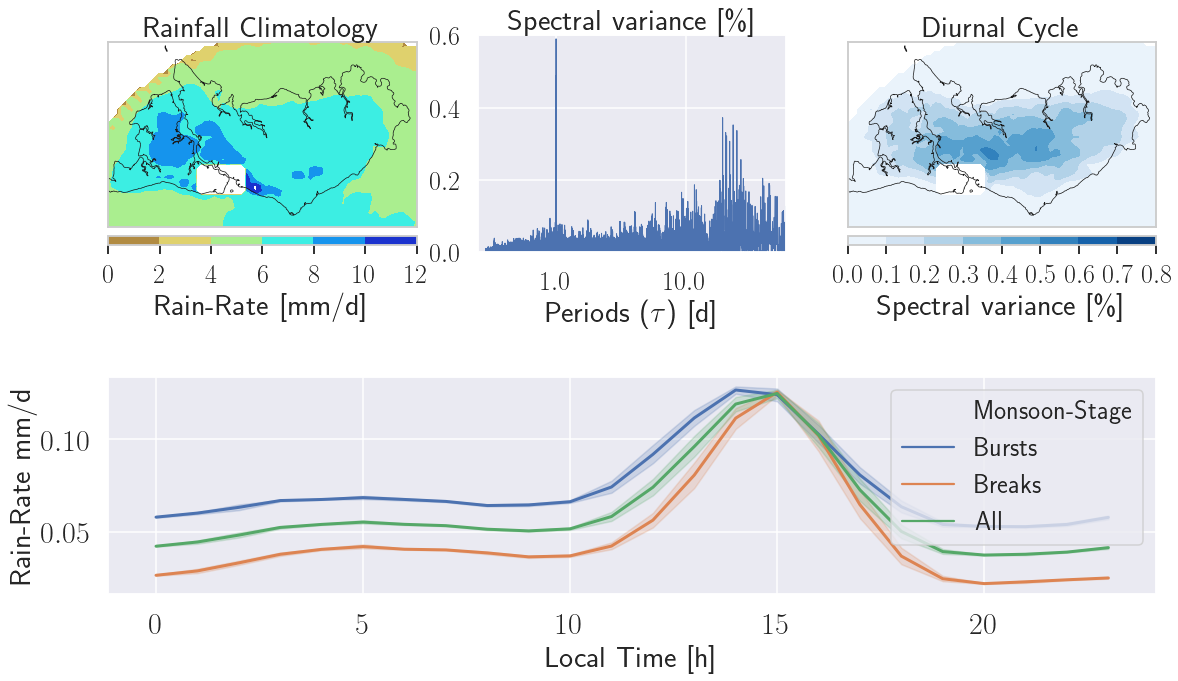

In [104]:
#Plot the diurnal Cycle
%matplotlib inline
nplot=1

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(5, 3)

sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
from matplotlib.ticker import ScalarFormatter
#Plot the output map
fig = plt.figure(figsize=(15,8))
cmap = colmap2.Blues
cmap2 = colmap.GMT_drywet
cmap.set_under('w'),cmap.set_bad('w')
cmap2.set_under('w'),cmap2.set_bad('w')
ax1 = plt.subplot(gs[:2, 0])
#ax1 = fig.add_subplot(231)
ax1.set_title('Rainfall Climatology', size=fontsize)
X, Y = np.meshgrid(lon.filled(-50), lat.filled(-50))
im = m1.contourf(X, Y, map1, np.arange(0,13,2), cmap=colmap.GMT_drywet, ax=ax1)

#im = m1.pcolormesh(lon.filled(-50), lat.filled(-50), map1, vmin=0, cmap=colmap.GMT_drywet, ax=ax1)
m1.drawcoastlines(linewidth=.7)
cbar = m1.colorbar(im , location='bottom', pad="5%")
cbar.set_label('Rain-Rate [mm/d]', size=fontsize)
cbar.ax.tick_params(labelsize=fontsize-4)

sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
ax2 = plt.subplot(gs[:2, 1])
sns.lineplot('x', "y", data=sns_data, ax=ax2, lw=1)
ax2.set(xscale="log")
ax2.set_xlim(0.25,60)
ax2.set_ylim(0,0.6)
ax2.set_xlabel('Periods ($\\tau$) [d]',size=fontsize)
ax2.set_title('Spectral variance [\%]',size=fontsize)
ax2.tick_params(labelsize=fontsize-4)
ax2.set_ylabel('')
ax2.xaxis.set_major_formatter(ScalarFormatter())
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})

ax3 = plt.subplot(gs[:2, 2])
im2 = m1.contourf(X, Y, map2, np.arange(0, 9)/10. ,cmap='Blues', ax=ax3)
m1.drawcoastlines(linewidth=.7)
ax3.set_title('Diurnal Cycle', size=fontsize)
cbar = m1.colorbar(im2,location='bottom',pad="5%")
cbar.set_label('Spectral variance [\%]', size=fontsize)
cbar.ax.tick_params(labelsize=fontsize-4)
# %%
#fig.subplots_adjust(right=0.98, bottom=0.03, top=0.99,left=0.01, hspace=0, wspace=0.17)
#'''
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
#fig, ax = plt.subplots(1, figsize=(15,10))
ax4 = plt.subplot(gs[3:, :])
sns.lineplot(x='Local Time', y='Rain-Rate', data=diurnacl_cycle, hue='Monsoon-Stage', lw=3, ax=ax4)
ax4.set_ylabel('Rain-Rate mm/d', fontsize=fontsize)
ax4.set_xlabel('Local Time [h]', fontsize=fontsize)
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%_H'))
ax4.legend(loc=0, fontsize=fontsize-4)
ax4.tick_params(labelsize=fontsize)
fig.subplots_adjust(bottom=0.01, top=0.98, left=0.01, right=0.98, hspace=0.1, wspace=0.2)
#fig.subplots_adjust(bottom=0.145, top=0.99, right=0.99, left=0.1)
nplot += 1; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

## 2.2 Local Extemes and the stage of the Monsoon

The above plots show that diurnal cycle is the most important mode of variability in the considered area. The island thunderstrom hector is the most extreme convective system that occurs at the time-scale at perdiods of 24 h. The Hector 'signal' is most pronounced during the Monsoon break period. Before studying Hector we split the CPOL area into *break* and *burst* period and investigate the occurrence of extremes during Monsoon *break* and *burst*. 

First we define extreme events by applying the 99th percentile threshold of the total 10min dataset. Then we define the break and burst events by the definition of Narsey et al. and calculate the number of burst and the number of break events during the CPOL era

In [105]:
#Now prepare the data
D = []
Mean = []
data = np.zeros([len(lat),len(lon)])
for i in (monsoon10m.index, breaks, bursts):
    tt = S.loc[i].dropna().values.astype('i')
    D.append((( np.ma.masked_less(rr[tt,:,:],thresh) * 0 ) + 1 ).sum(axis=0))
    Mean.append(np.nanmean(rr[tt,:,:], axis=0) * 24)
mask = ((D[0] * 0 )+1)

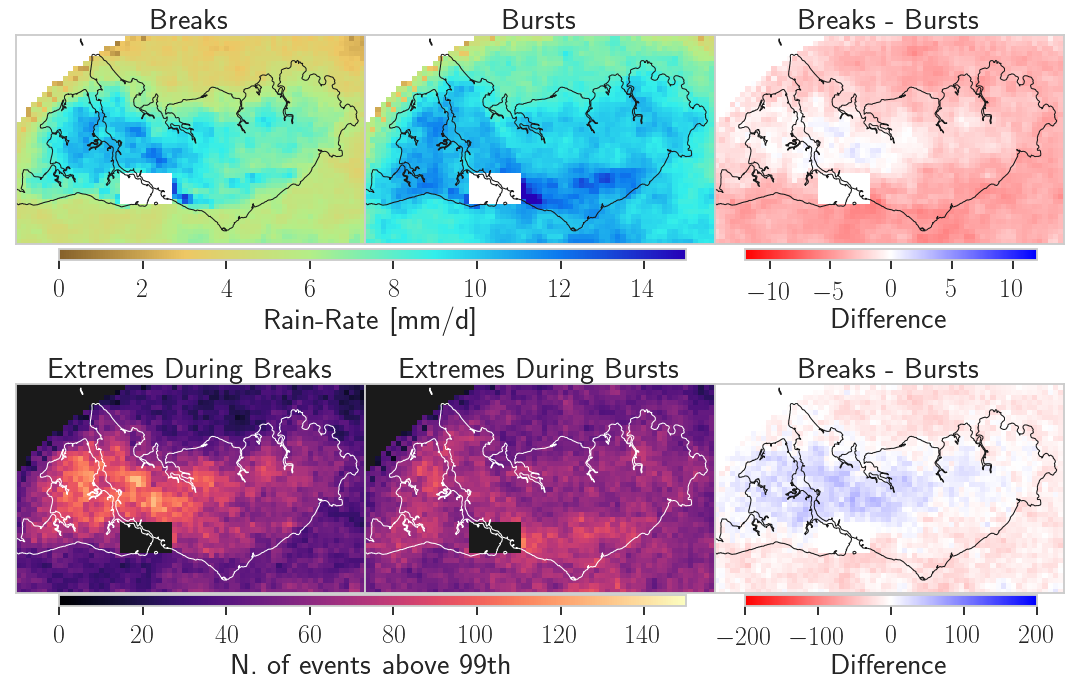

In [106]:
# Now Plot the maps
mpld3.disable_notebook()
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
maxval =[(0,15), (0,15), (-12,12), (0, 150), (0, 150), (-200, 200)]
names=['Breaks', 'Bursts', 'Breaks - Bursts',
      'Extremes During Breaks', 'Extremes During Bursts', 'Breaks - Bursts']
cmap_list = [(colmap.GMT_drywet,'k'), (colmap.GMT_drywet,'k'), (colmap.GMT_polar_r,'k'),
       (mpl.cm.magma,'w'), (mpl.cm.magma,'w'), (colmap.GMT_polar_r,'k')]

C = [Mean[1]*1.5, Mean[2], Mean[1]*1.5 - Mean[2], D[1]*1.2, D[2], D[1]*1.2 - D[2]]
fig = plt.figure(figsize=(15,10))
mask = ((D[0] * 0 )+1)
im=[]
for i, idx in enumerate(C):
    ax = fig.add_subplot(2,3,i+1)
    data = np.zeros([len(lat),len(lon)])
    colm, coast = cmap_list[i]
    colm.set_bad(dict(k='w', w='k')[coast])
    colm.set_under(dict(k='w', w='k')[coast])
    try:
        im.append(m.pcolormesh(lon, lat, mask*C[i].filled(0),vmin=maxval[i][0],vmax=maxval[i][1],cmap=colm))
    except AttributeError:
        im.append(m.pcolormesh(lon, lat, mask*C[i],vmin=maxval[i][0],vmax=maxval[i][1], cmap=colm))
    m.drawcoastlines(color=coast)
    ax.set_title('%s'%names[i],size=fontsize)
fig.subplots_adjust(right=0.98, bottom=0.01, top=0.98,left=0.01, hspace=0, wspace=0)
cbar_ax1 = fig.add_axes([0.05, 0.57,0.58, 0.015])
cbar1 = fig.colorbar(im[0], cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=fontsize-4)
cbar1.set_label(u'Rain-Rate [mm/d]',size=fontsize)
cbar_ax2 = fig.add_axes([0.685, 0.57,0.27, 0.015])
cbar2 = fig.colorbar(im[2], cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=fontsize-4)
cbar2.set_label(u'Difference',size=fontsize)
cbar_ax3 = fig.add_axes([0.05, 0.09,0.58, 0.015])
cbar3 = fig.colorbar(im[3], cax=cbar_ax3, orientation='horizontal')
cbar3.ax.tick_params(labelsize=fontsize-4)
cbar3.set_label(u'N. of  events above 99th%',size=fontsize)
cbar_ax4 = fig.add_axes([0.685, 0.09,0.27, 0.015])
cbar4 = fig.colorbar(im[-1], cax=cbar_ax4, orientation='horizontal')
cbar4.ax.tick_params(labelsize=fontsize-4)
cbar4.set_ticks([-200, -100, 0, 100, 200])
cbar4.set_label(u'Difference',size=fontsize)
nplot = 3 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

# 2.0 Ensemble Simulations of Islands Thuderstorms

To investigate how well Extreme Events caused by local tropicsl Island Thunderstorms are represented in a numerical model we choose a period of 8 consecutive occurring Hector events over the Tiwi Island during the Monsoon break period in November 2006. To increase the sample size for more robust statistics we create ensemble of 8 members. The ensemble is created by 8 different initialisation times. 

In [6]:
#Read the Simulation data
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
## First define the file names of the simulations
UMdir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM', 'darwin', 'RA1T')
ensembles = ('20061109T1200Z', '20061109T1800Z', '20061110T0000Z', '20061110T0600Z', '20061110T1200Z',
             '20061110T1800Z',  '20061111T0000Z', '20061111T1200Z')
Simend = '20061119_0600-%s'%remap_res
### Define the resolutions we have with help of a named tuple
Simulation = namedtuple('Simulation', 'member dataset resolution')
UM133 = Simulation(member=ensembles, dataset=[], resolution=1.33)
UM044 = Simulation(member=ensembles, dataset=[], resolution=0.44)
OBS = Simulation(member=['CPOL'], dataset=[], resolution=2.55)
# Now construct the filenames of the UM - rainfall ouput and get the overlapping time periods
start, end = [], []
for ens in ensembles:
    date = datetime.strptime(ens,'%Y%m%dT%H%MZ')
    umf133 = 'um-1p33km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    umf044 = 'um-0p44km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    time133 = xr.open_dataset(os.path.join(UMdir, umf133)).coords['t'].values
    time044 = xr.open_dataset(os.path.join(UMdir, umf044)).coords['t'].values
    start.append((time133[0], time044[0]))
    end.append((time133[-1], time044[-1]))
end = np.min(np.array(end), axis=0)
start = np.max(np.array(start), axis=0)
# Now get the datasets for these overlapping time periods
for nn, ens in enumerate(ensembles):
    date = datetime.strptime(ens,'%Y%m%dT%H%MZ')
    umf133 = 'um-1p33km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    umf044 = 'um-0p44km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    for file, res, ntuple, n in ((umf133, '1p33km', UM133, 0), (umf044, '0p44km', UM044, 1)):
        fn = os.path.join(UMdir, file)
        with xr.open_dataset(fn) as ds:
            um_times = pd.DatetimeIndex(ds.coords['t'].values).round('1min')
            iloc_s = abs(um_times - pd.Timestamp(start[n])).argmin()
            iloc_e = abs(um_times - pd.Timestamp(end[n])).argmin()
            
        ntuple.dataset.append(xr.open_dataset(fn).isel(t=list(range(iloc_s,iloc_e+1)), surface=[0]))
        ntuple.dataset[-1].coords['t'] = um_times[iloc_s:iloc_e+1].round('5min')
# Now get the overlapping time periods for the observations


for nn,file in enumerate((WOHF, WOHFv1, CMORPHF, WOHFv2)):
    with nc(file) as ds:
        obs_time = pd.DatetimeIndex(num2date(ds.variables['t'][:], ds.variables['t'].units))
        iloc_s = abs(obs_time - pd.Timestamp(start[0])).argmin()
        iloc_e = abs(obs_time - pd.Timestamp(end[0])).argmin()

    ds = xr.open_dataset(file)
    ds.coords['t'] = obs_time
    if nn > 0:
        try:
            slon = np.fabs(ds.variables['longitude'].values[0,:] - min(lon)).argmin()
            elon = np.fabs(ds.variables['longitude'].values[0,:] - max(lon)).argmin()+1
            slat = np.fabs(ds.variables['latitude'].values[:,0] - min(lat)).argmin()
            elat = np.fabs(ds.variables['latitude'].values[:,0]- max(lat)).argmin()+1
        except IndexError:
            slon = np.fabs(ds.variables['longitude'].values[:] - min(lon)).argmin()
            elon = np.fabs(ds.variables['longitude'].values[:] - max(lon)).argmin()+1
            slat = np.fabs(ds.variables['latitude'].values[:] - min(lat)).argmin()
            elat = np.fabs(ds.variables['latitude'].values[:]- max(lat)).argmin()+1
        try:
            OBS.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1)), y=range(slon,elon), x=range(slat,elat)))
        except ValueError:
            OBS.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1)), longitude=range(slon,elon), latitude=range(slat,elat)))
    else:
        OBS.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1))))

Now lets try concatenating the UM ensemble data into one big data-array to construct the percentiles and compare it to the CPOL observations. 

In [7]:
# Concatenate the um datasets
UM133ens = xr.concat(UM133.dataset, dim='ens')
UM044ens = xr.concat(UM044.dataset, dim='ens')

In [86]:
data = dict(UM133mean=UM133ens['lsrain'].mean(axis=(2,3,4)).mean(axis=0).values,
            UM133min=UM133ens['lsrain'].mean(axis=(2,3,4)).min(axis=0).values,
            UM133max=UM133ens['lsrain'].mean(axis=(2,3,4)).max(axis=0).values,
            UM044mean=UM044ens['lsrain'].mean(axis=(2,3,4)).mean(axis=0).values,
            UM044min=UM044ens['lsrain'].mean(axis=(2,3,4)).min(axis=0).values,
            UM044max=UM044ens['lsrain'].mean(axis=(2,3,4)).max(axis=0).values)
t1 = pd.DatetimeIndex(UM133ens.coords['t'].values).round('1min').tz_localize(utc).tz_convert(timezone).tz_localize(None)
t2 = pd.DatetimeIndex(UM044ens.coords['t'].values).round('1min').tz_localize(utc).tz_convert(timezone).tz_localize(None)
t3 = pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).round('10min').tz_localize(utc).tz_convert(timezone).tz_localize(None)
plot_data2 = pd.DataFrame(data, index=t1-pd.Timedelta('5min')).loc[t3]
plot_data2['CPOL'] = CPOL=OBS.dataset[1]['lsrain'].mean(axis=(1,2)).values
plot_data2.to_pickle('../slides/WOH_aavg.pkl')

## 2.1 A Week of Hector
Now we compare the ensemble timeseries of the simulated rainfall for the 1.33km and 0.44km Simulations with the CPOL observations.


In [8]:
time, obs, rain = [], [], []
for e in range(len(ensembles)):
    r1 = list(UM133ens.variables['lsrain'][e].mean(axis=(1,2,3)).values)
    r2 = list(UM044ens.variables['lsrain'][e].mean(axis=(1,2,3)).values)
    obs+=len(r1)*['UM 1.33km'] + len(r2)*['UM 0.44km']
    t1 = pd.DatetimeIndex(UM133ens.coords['t'].values).tz_localize(utc).tz_convert(timezone).tz_localize(None).to_pydatetime()
    rain += r1 + r2
    t2 = pd.DatetimeIndex(UM044ens.coords['t'].values).tz_localize(utc).tz_convert(timezone).tz_localize(None).to_pydatetime()
    time += list(t1) + list(t2)

r3 = list(OBS.dataset[1].variables['lsrain'].mean(axis=(1,2)).values)
t3 = list(pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone).tz_localize(None).to_pydatetime())
o3 = len(r3)*['CPOL']
rain += r3
obs += o3
time += t3
plot_data = pd.DataFrame({'rain-rate':rain, 'time':time, 'Type':obs})


In [49]:
plot_data.to_pickle('../slides/WOH_aavg.pkl')

In [250]:
#Plot area avg TS
import matplotlib.dates as mdates
mpld3.disable_notebook()
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
myFmt = mdates.DateFormatter('%d/%m')
#
#Get the minimum time period that is covered by all simulations and also observations
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
sns.lineplot(x='time', y='rain-rate', hue='Type', ax=ax, data=plot_data, lw=1.3)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.9)
ax.legend(loc=0, fontsize=fontsize-14)
ax.tick_params(labelsize=fontsize-14)
#ax.set_xlim(plot_data.time.iloc[0], plot_data.time.iloc[-1])
ax.set_ylim(-0.001,0.5)
ax.set_ylabel('Rain-Rate [mm/h]', fontsize=fontsize-12)
_ = ax.xaxis.set_major_formatter(myFmt)
_ = ax.set_xlabel('')
#_ = ax.set_title('Comparison of Area-Avg Rainfall', fontsize=fontsize)
fig.subplots_adjust(bottom=0.4, top=0.93, right=0.83, left=0.1)
d3plot = mpld3.display(fig)
display(d3plot)
#nplot+=1; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

In [251]:
import pickle
f =  open('../slides/d3plot.dmp','wb')
pickle.dump(d3plot, f)
f.close()

790506

## 2.1.1 Maps of Rainfall
Now lets look at some animations of UM rainfall occuring over the Tiwi-islands and compare it to the cpol observations

In [31]:
#Create Animation
#m2,m1 = None, None
mpld3.disable_notebook()
first = True
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(right=0.99, bottom=0.01, top=0.98,left=0.01, hspace=0, wspace=0)
UM = UM044ens
obs = OBS.dataset[1]
lat2, lon2 = obs.variables['latitude'][:,0], obs.variables['longitude'][0,:]

colm = colmap2.Blues
if m1 is None:
    m1 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2),
             resolution='f', area_thresh=1)
colm.set_under('w',alpha=0)
colm.set_bad('w',alpha=0)
tsteps = pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone).tz_localize(None).to_pydatetime()
start = np.fabs((pd.Timestamp('2006-11-09 14:30')-pd.DatetimeIndex(tsteps)).total_seconds()).argmin()
end = np.fabs((pd.Timestamp('2006-11-21 18:30')-pd.DatetimeIndex(tsteps)).total_seconds()).argmin()
for tt in range(start, end):
    fname = os.path.join(outdir, 'Ens-Comparison_%05i.png'%tt)
    break
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s ....    '%os.path.basename(fname))
    sys.stdout.flush()
    if first:
        obs_data = np.ma.masked_less(obs.variables['lsrain'][:].values, 2)
        um_data = np.ma.masked_less(UM.variables['lsrain'][:].values, 2)
        lat1, lon1 = obs.variables['latitude'][:,0], obs.variables['longitude'][0,:]
        lat2, lon2 = UM.coords['lat'][:], UM.coords['lon'][:]
        ax = [fig.add_subplot(3,3,1)]
        m1.pcolormesh(topolon, topolat, ls.hillshade(topo[:], vert_exag=1), cmap=plt.cm.gist_earth, ax=ax[0])
        im = [m1.pcolormesh(lon1, lat1, obs_data[tt].filled(-1.),vmin=0.0,vmax=15,cmap=colm, shading='gouraud')]
        #m1.drawcoastlines(linewidth=0.8)
        cbar_ax = fig.add_axes([0.12, 0, 0.74, 0.01])
        cbar=fig.colorbar(im[-1], cax=cbar_ax, orientation='horizontal')
        cbar.ax.tick_params(labelsize=24)
        tit = ['Obs']
        ax[-1].set_title('Obs', fontsize=24)
        
        for i in range(1,9):
            ax.append(fig.add_subplot(3,3,i+1))
            if m2 is None:
                m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2), resolution='f',
                             area_thresh=1)
            m2.pcolormesh(topolon, topolat, ls.hillshade(topo[:], vert_exag=1), cmap=plt.cm.gist_earth, ax=ax[-1])
            im.append(m2.pcolormesh(lon2, lat2, um_data[i-1][tt,0].filled(-1.),vmin=0.0,vmax=15,cmap=colm,shading='gouraud'))
            tit.append( r'Ens. \rom{{{}}}'.format(i))
            ax[-1].set_title(tit[-1],fontsize=24)
            #m2.drawcoastlines(linewidth=0.8)
        first = False
    else:
        im[0].set_array((obs_data[tt]).filled(-1).ravel())
        for i in range(1,9):
            im[i].set_array((um_data[i-1][tt,0]).filled(-1).ravel())  
    cbar.set_label('Rain-Rates at %s [mm/h]'%tsteps[tt].strftime('%Y-%m-%d %H:%M LT'), fontsize=24)
    fig.savefig(fname, bbox_inches='tight', format='png', dpi=72)
sys.stdout.write('\n')
fig.clf(), plt.close()
dest_dir = os.path.abspath('Vid')
_ = make_mp4_from_frames(outdir, dest_dir, 'WeekOfHector-Ens-2.mp4', 4, glob='Ens-Comparison_?????')

In [32]:
os.chdir('/home/unimelb.edu.au/mbergemann/Work/Programming/Extremes/python/')

In [33]:
#Plot Animatoin
import io
import base64
from IPython.display import HTML
outvid=os.path.join('Vid','WeekOfHector-Ens-3.mp4')
video = io.open(outvid, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="950" height="500" loop="true" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### Maps of Rainfall (0.44km)

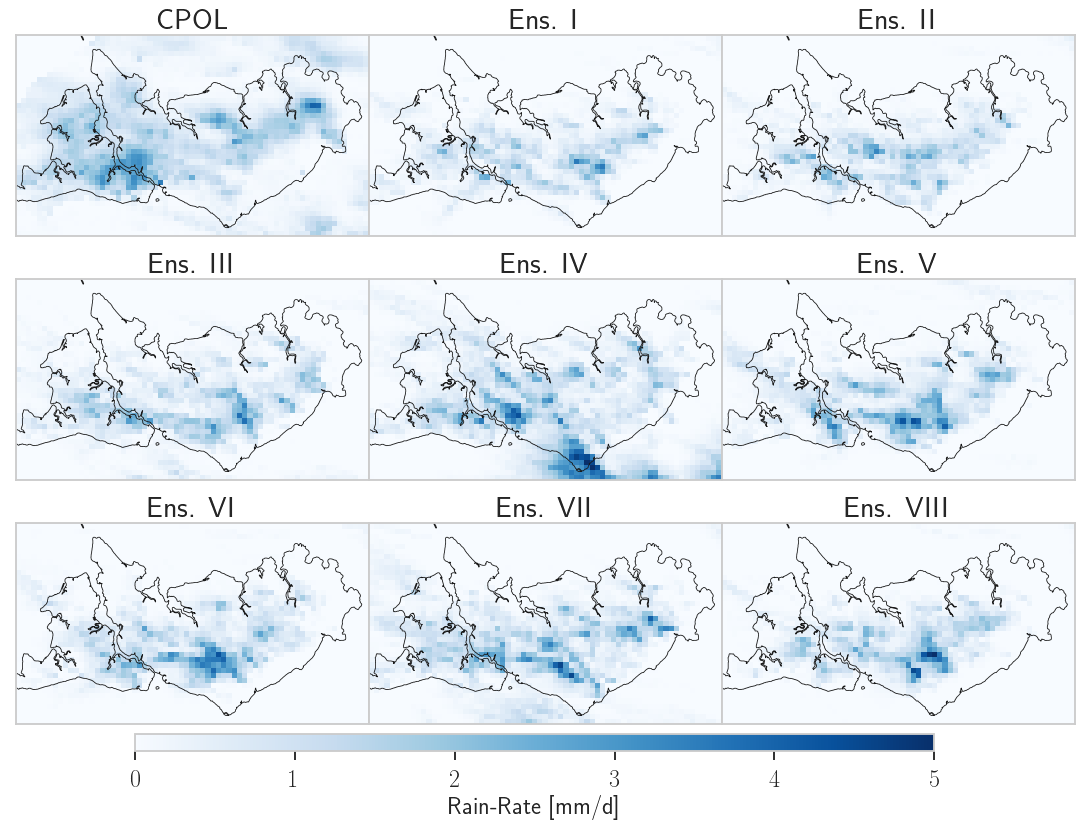

In [58]:
#Create the avg. maps of rainfall 0.44km
#m1, m2 = None, None
mpld3.disable_notebook()
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
rom = {1:'i', 2:'ii', 3:'iii', 4:'iv', 5:'v', 6:'vi', 7:'vii', 8:'viii'}
fig = plt.figure(figsize=(15,12))

UM = UM044ens.groupby('t.day').sum(dim='t').mean(dim='day')
obs = OBS.dataset[1].groupby('t.day').sum(dim='t').mean(dim='day')
colm = colmap2.Blues

colm.set_under('w', alpha=0)
colm.set_bad('w', alpha=0)
tsteps = pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone).to_pydatetime()
obs_data = np.ma.masked_less(obs.variables['lsrain'][:].values, -0.01) / 6
um_data = np.ma.masked_less(UM.variables['lsrain'][:].values, -0.01) / 6
lat1, lon1 = obs.variables['latitude'][:,0], obs.variables['longitude'][0,:]
lat2, lon2 = UM.coords['lat'][:], UM.coords['lon'][:]
ax = [fig.add_subplot(3,3,1)]
if m2 is None:
    m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2),
             resolution='f', area_thresh=1)
if m1 is None:
    m1 = Basemap(llcrnrlat=min(lat1), llcrnrlon=min(lon1), urcrnrlat=max(lat1), urcrnrlon=max(lon1),
             resolution='f', area_thresh=1)
#m[0].pcolormesh(topolon, topolat, ls.hillshade(topo[:], vert_exag=1), cmap='gray', ax=ax[0])
im = [m2.pcolormesh(lon1, lat1, obs_data,vmin=0.0,vmax=5,cmap=colm)]
m2.drawcoastlines(linewidth=0.8)
cbar_ax = fig.add_axes([0.12, 0.12, 0.74, 0.02])
cbar=fig.colorbar(im[-1], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Rain-Rate [mm/d]',size=24)
tit = ['CPOL']
ax[-1].set_title('CPOL', fontsize=fontsize)
for i in range(1,9):
    if m2 is None:
        m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2),
                         resolution='f', area_thresh=1)
    ax.append(fig.add_subplot(3,3,i+1))
    m2.drawcoastlines(linewidth=0.8)
    im.append(m2.pcolormesh(lon2, lat2, um_data[i-1][0],vmin=0.0,vmax=5,cmap=colm))
    tit.append('Ens. %s'%rom[i].upper())
    ax[-1].set_title(tit[-1],fontsize=fontsize)
fig.subplots_adjust(right=0.99, bottom=0.15, top=0.95,left=0.01, hspace=0.2, wspace=0.0)
nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

### Maps of Rainfall (1.33km)

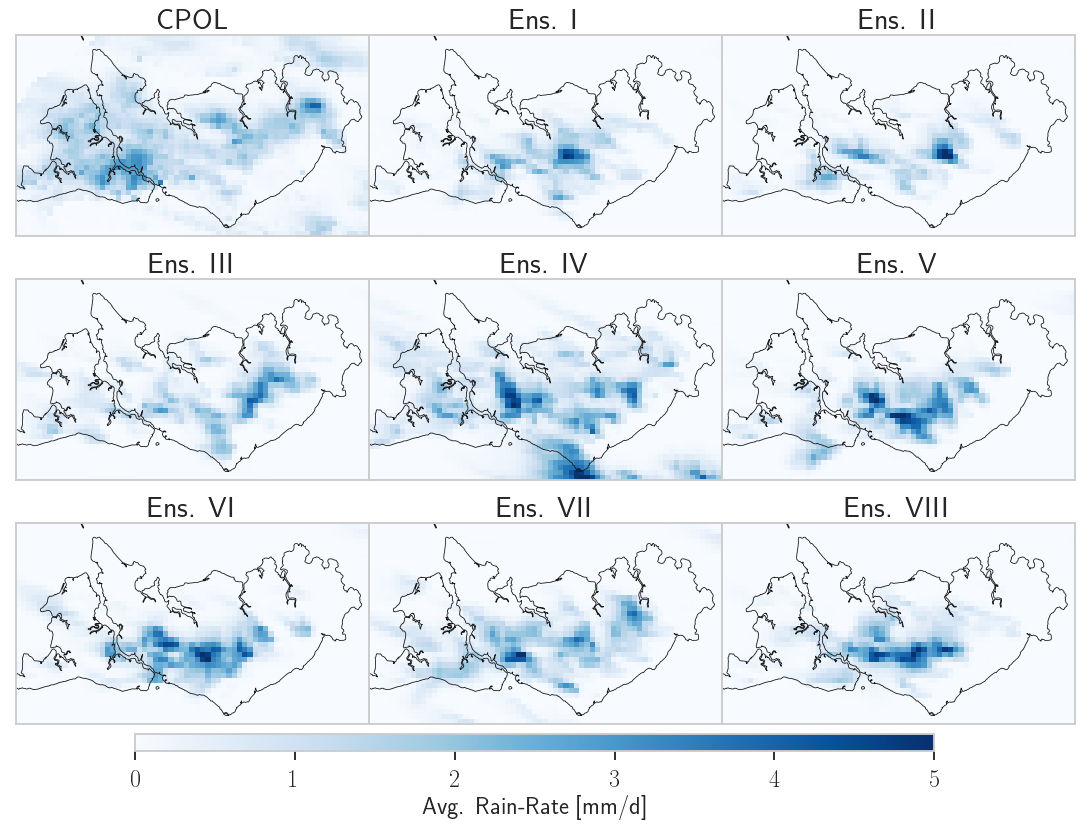

In [59]:
#Create the avg maps of rainfall for 1.33km
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
fig = plt.figure(figsize=(15,12))
UM = UM133ens.groupby('t.day').sum(dim='t').mean(dim='day')
obs = OBS.dataset[1].groupby('t.day').sum(dim='t').mean(dim='day')
colm = colmap2.Blues
colm.set_under('w', alpha=0)
colm.set_bad('w', alpha=0)
tsteps = pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone).to_pydatetime()
obs_data = np.ma.masked_less(obs.variables['lsrain'][:].values, -0.01) / 6
um_data = np.ma.masked_less(UM.variables['lsrain'][:].values, -0.01) / 6
lat1, lon1 = obs.variables['latitude'][:,0], obs.variables['longitude'][0,:]
lat2, lon2 = UM.coords['lat'][:], UM.coords['lon'][:]
ax = [fig.add_subplot(3,3,1)]
if m1 is None:
    m1 = Basemap(llcrnrlat=min(lat1), llcrnrlon=min(lon1), urcrnrlat=max(lat1), urcrnrlon=max(lon1), resolution='f',
                 area_thresh=1)
#m[0].pcolormesh(topolon, topolat, ls.hillshade(topo[:], vert_exag=1), cmap='gray', ax=ax[0])
im = [m2.pcolormesh(lon1, lat1, obs_data,vmin=0.0,vmax=5,cmap=colm)]
m2.drawcoastlines(linewidth=0.8)
cbar_ax = fig.add_axes([0.12, 0.12, 0.74, 0.02])
cbar=fig.colorbar(im[-1], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Avg. Rain-Rate [mm/d]',size=24)
tit = ['CPOL']
ax[-1].set_title('CPOL', fontsize=fontsize)
for i in range(1,9):
    if m2 is None:
        m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2), resolution='f',
                     area_thresh=1)
    ax.append(fig.add_subplot(3,3,i+1))
   
    m2.drawcoastlines(linewidth=0.8)
            #m[-1].shadedrelief()
    im.append(m2.pcolormesh(lon2, lat2, um_data[i-1][0],vmin=0.0,vmax=5,cmap=colm))
    tit.append('Ens. %s'%rom[i].upper())
    ax[-1].set_title(tit[-1],fontsize=fontsize)
fig.subplots_adjust(right=0.99, bottom=0.15, top=0.95,left=0.01, hspace=0.2, wspace=0.0)
nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

### Ensemble mean and std

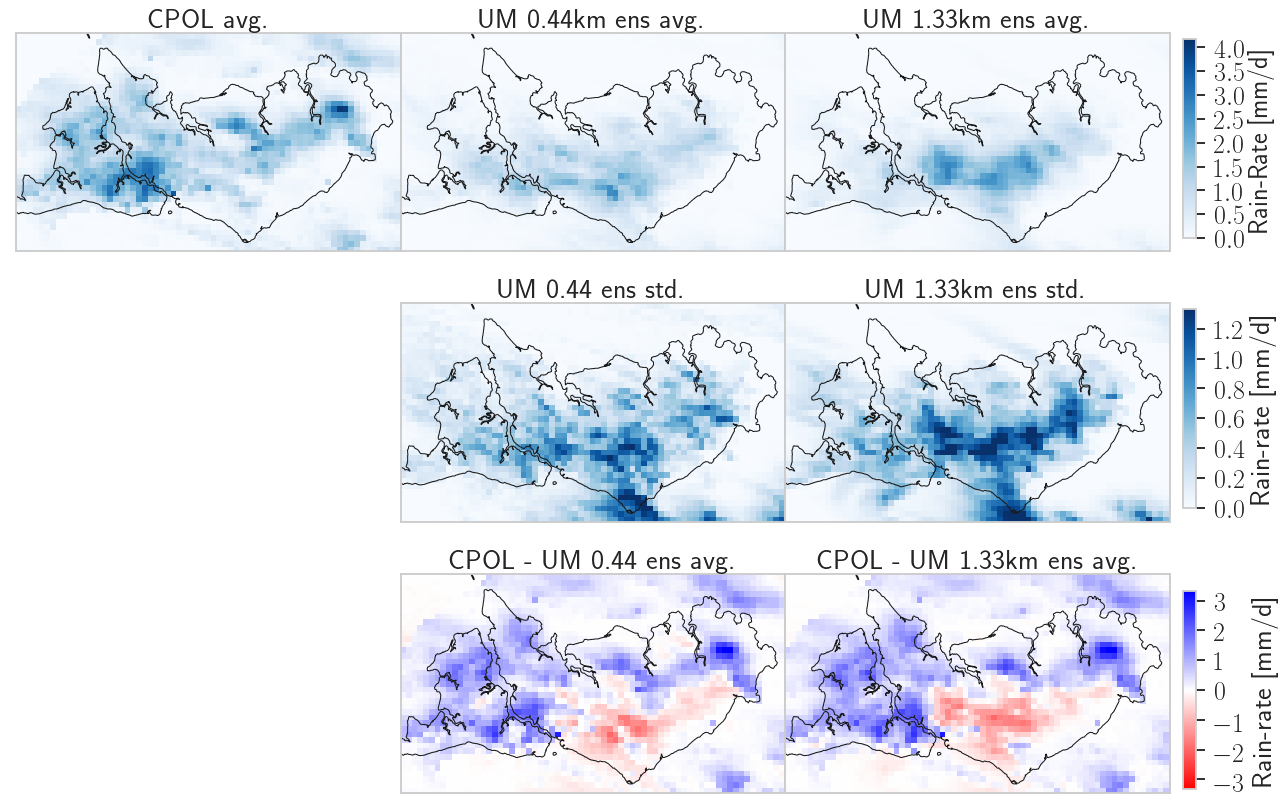

In [60]:
#Plet the avg maps for comparison
fig = plt.figure(figsize=(18,12))
#sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
UM_2 = UM133ens.groupby('t.day').sum(dim='t').mean(dim='day')
UM_1 = UM044ens.groupby('t.day').sum(dim='t').mean(dim='day')
obs = OBS.dataset[1].groupby('t.day').sum(dim='t').mean(dim='day')
colm = colmap2.Blues
colm.set_under('w', alpha=0)
tsteps = pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone).to_pydatetime()
obs_data = np.ma.masked_less(obs.variables['lsrain'][:].values, -0.01)
data = [obs_data[1:-1]/6,
        np.ma.masked_less(UM_1.variables['lsrain'][:].values, -0.01).mean(axis=0)[0]/6,
        np.ma.masked_less(UM_2.variables['lsrain'][:].values, -0.01).mean(axis=0)[0]/6,
        None,
        np.ma.masked_less(UM_1.variables['lsrain'][:].values/6, -0.01).std(axis=0)[0],
        np.ma.masked_less(UM_2.variables['lsrain'][:].values/6, -0.01).std(axis=0)[0]
       ]

data.append(None)

data.append(data[0] - data[1])
data.append(data[0] - data[2])
UM_1min = np.ma.masked_less(UM_1.variables['lsrain'][:].values, -0.01).min(axis=0)[0]
UM_2min = np.ma.masked_less(UM_2.variables['lsrain'][:].values, -0.01).min(axis=0)[0]

UM_1max = np.ma.masked_less(UM_1.variables['lsrain'][:].values, -0.01).max(axis=0)[0]
UM_2max = np.ma.masked_less(UM_2.variables['lsrain'][:].values, -0.01).max(axis=0)[0]

#data.append(None)
#data.append(UM_1max - UM_1min)
#data.append(UM_1max - UM_1min)


lat1, lon1 = obs.variables['latitude'][:,0], obs.variables['longitude'][0,:]
lat2, lon2 = UM_1.coords['lat'][:], UM_1.coords['lon'][:]
ax = [fig.add_subplot(3,3,1)]
#m[0].pcolormesh(topolon, topolat, ls.hillshade(topo[:], vert_exag=1), cmap='gray', ax=ax[0])
im = [m2.pcolormesh(lon1, lat1, obs_data/6,vmin=0.0,vmax=25/6,cmap=colm)]
m2.drawcoastlines()
#cbar_ax = fig.add_axes([0.14, 0.33, 0.74, 0.01])
#cbar=fig.colorbar(im[-1], cax=cbar_ax, orientation='horizontal')
#cbar.ax.tick_params(labelsize=24)
#cbar.set_label('Avg. Rain-rate [mm/d]',size=24)
tit = ['CPOL avg.', 'UM 0.44km ens avg.', 'UM 1.33km ens avg.',
       None, 'UM 0.44 ens std.', 'UM 1.33km ens std.',
       None, 'CPOL - UM 0.44 ens avg.' ,'CPOL - UM 1.33km ens avg.',
       None, 'UM 0.44 ens range', 'UM 1.33km ens range']
colors = {1:colm, 2:colm, 4:colm, 5:colm,
          7:colmap.GMT_polar_r, 8:colmap.GMT_polar_r,
         10:colm, 11:colm}
Range = {1:(0.0, 25/6), 2:(0.0, 25/6), 4:(0,8/6), 5:(0,8/6), 7:(-20/6,20/6), 8:(-20/6,20/6), 10:(0,30/6), 11:(0,30/6)}
height = {2:0.682, 5:0.37, 8:0.044, 11:0.05}
ax[-1].set_title('CPOL avg.', fontsize=fontsize-2)
cbar_ax = [fig.add_axes([0.91, height[2], 0.01, 0.23])]
cbar = [fig.colorbar(im[-1], cax=cbar_ax[-1], orientation='vertical')]
cbar[-1].ax.tick_params(labelsize=fontsize-4)
cbar[-1].set_label('Rain-Rate [mm/d]',size=fontsize-4)
for i in range(1,len(data)):
    if data[i] is not None:
        ax.append(fig.add_subplot(3,3,i+1))
            #m[-1].shadedrelief()
        im.append(m2.pcolormesh(lon2, lat2, data[i],vmin=Range[i][0],vmax=Range[i][1],cmap=colors[i]))
        m2.drawcoastlines()
        ax[-1].set_title(tit[i],fontsize=fontsize-2)
        if i in (5, 8, 11):
            cbar_ax.append(fig.add_axes([0.91, height[i], 0.01, 0.23]))
            cbar.append(fig.colorbar(im[-1], cax=cbar_ax[-1], orientation='vertical'))
            cbar[-1].ax.tick_params(labelsize=fontsize-4)
            cbar[-1].set_label('Rain-rate [mm/d]',size=fontsize-2)
fig.subplots_adjust(right=0.9, bottom=0.01, top=0.95,left=0.01, hspace=0.0, wspace=0)
nplot+=1 ; _ = fig.savefig('Vid/Fig_%i03.png'%nplot, bbox_inches='tight', format='png', dpi=300)

## 2.1.2 The Simulated Diurnal Cycle

In [62]:
data, time, model = [], [], []
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
for i in range(len(ensembles)):
    d1 = UM133.dataset[i].groupby('t.hour').mean(dim='t').mean(dim=('surface','lat','lon'))
    d2 = UM044.dataset[i].groupby('t.hour').mean(dim='t').mean(dim=('surface','lat','lon'))
    t1 = pd.Series(d1.variables['lsrain'].values, index=(d1.variables['hour'].values+9) % 24 ).sort_index(inplace=False)
    t2 = pd.Series(d2.variables['lsrain'].values, index=(d2.variables['hour'].values+9) % 24 ).sort_index(inplace=False)
    time += list(t1.index) + list(t2.index)
    data += list(t1.values) + list(t2.values)
    model += len(t1)*['UM 1.33km'] + len(t2)*['UM 0.44km']
cpol_1 = OBS.dataset[1].groupby('t.hour').mean(dim='t').mean(dim=('y','x'))
obs_S = pd.Series(cpol_1.variables['lsrain'].values, index=(cpol_1.variables['hour'].values+9) % 24 ).sort_index(inplace=False)
data += list(obs_S.values)
time += list(obs_S.index)
model += len(obs_S)*['Cpol']
plot_data = pd.DataFrame(dict(data=data, time=time, Type=model))
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)
#mpld3.enable_notebook()

### Location and timing of daily rainfall peaks

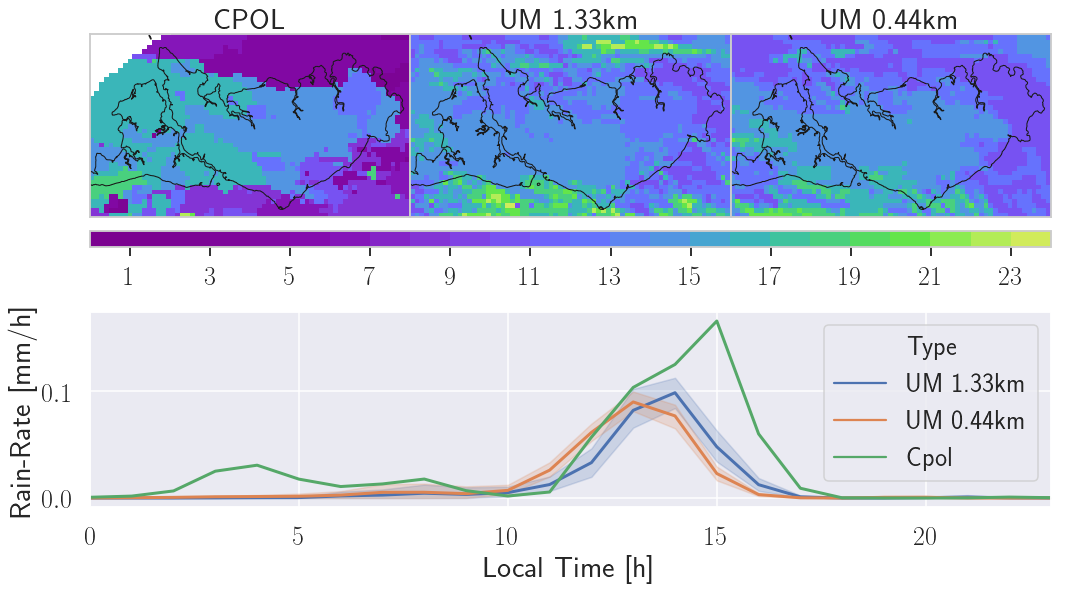

In [81]:
#Plot the maps
plt.close()
mpld3.disable_notebook()
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':False})
um_1 = UM044ens.groupby('t.hour').mean(dim='t').mean(dim=('surface'))
um_2 = UM133ens.groupby('t.hour').mean(dim='t').mean(dim=('surface'))
obs  = OBS.dataset[1].groupby('t.hour').mean(dim='t')

time = (um_1.hour + 9) % 24

data = [obs, um_2, um_1]

fig = plt.figure(figsize=(15,7))
lat1, lon1 = OBS.dataset[1].variables['latitude'].values[:,0], OBS.dataset[1].variables['longitude'].values[0,:]
lat2, lon2 = um_1.coords['lat'][:], um_1.coords['lon'][:]
fig.subplots_adjust(right=0.94, bottom=0.025, top=0.98,left=0.01, hspace=0, wspace=0)
first = True
val_max = 2
colm = colmap2.Blues
colm.set_under('w', alpha=0)
colm.set_bad('w', alpha=0)

#ax = [fig.add_subplot(2,3,1)]
mm, im = [], []
col = 2
for i in range(24):
    #break
    fname_1 = os.path.join(outdir, 'DiurnalCycle_%02i.png'%i)
    if first:
        for col in range(1, 7):
            if col != 4:
                ax1 = fig.add_subplot(2,3,col)
                m2.drawcoastlines(linewidth=0.8)
            if col == 1:
                ax1.set_title('CPOL',fontsize=fontsize)
                _ = im.append(m2.pcolormesh(lon1, lat1, obs['lsrain'].values[i],  shading='gouraud', vmin=0.1, vmax=val_max, cmap=colm))
            elif col == 2:
                ax1.set_title('UM 1.33km mean', fontsize=fontsize)
                _ = im.append(m2.pcolormesh(lon2, lat2, um_2['lsrain'].mean(dim='ens').values[i],  shading='gouraud', vmin=0.1, vmax=val_max, cmap=colm))
            elif col == 3:
                ax1.set_title('UM 0.44km mean', fontsize=fontsize)
                _ = im.append(m2.pcolormesh(lon2, lat2, um_1['lsrain'].mean(dim='ens').values[i],  shading='gouraud', vmin=0.1, vmax=val_max, cmap=colm))
            elif col == 5:
                ax1.set_title('UM 1.33km std', fontsize=fontsize)
                _ = im.append(m2.pcolormesh(lon2, lat2, um_2['lsrain'].std(dim='ens').values[i],  shading='gouraud', vmin=0.1, vmax=val_max, cmap=colm))
            elif col == 6:
                ax1.set_title('UM 0.44km std', fontsize=fontsize)
                _ = im.append(m2.pcolormesh(lon2, lat2, um_2['lsrain'].std(dim='ens').values[i],  shading='gouraud', vmin=0.1, vmax=val_max, cmap=colm))      
         
                cbar_ax = fig.add_axes([0.14, 0.0, 0.74, 0.02])
                cbar=fig.colorbar(im[-1], cax=cbar_ax, orientation='horizontal')
                _ = cbar.ax.tick_params(labelsize=fontsize-4)
        first = False
    else:
        ###MEAN
        im[0].set_array(obs['lsrain'].values[i].ravel())
        im[1].set_array(um_2['lsrain'].mean(dim='ens').values[i].ravel())
        im[2].set_array(um_1['lsrain'].mean(dim='ens').values[i].ravel())
        ###STD
        im[-2].set_array(um_2['lsrain'].std(dim='ens').values[i].ravel())
        im[-1].set_array(um_1['lsrain'].std(dim='ens').values[i].ravel())
    cbar.set_label('Rain-Rate at %2i LT [mm/h]'%((i+9.5)%24),size=fontsize)
    fig.savefig(fname_1, bbox_inches='tight', format='png', dpi=72)
    #break
dest_dir = os.path.abspath('Vid')
make_mp4_from_frames(outdir, dest_dir, 'WeekOfHector-Diurnal-2.mp4', 4, glob='DiurnalCycle_??')
fig.clf()
plt.close()
day = (time[1:5] - 9) % 24
night = (time[5:5+4] - 9) % 24
obs_diff = obs['lsrain'][day].sum(dim='hour') - obs['lsrain'][night].sum('hour')
um_1_diff = um_1['lsrain'][day].sum(dim='hour') - um_1['lsrain'][night].sum('hour')
um_2_diff = um_2['lsrain'][day].sum(dim='hour') - um_2['lsrain'][night].sum('hour')

mask = np.ma.masked_invalid(obs['lsrain'].values) * 0 + 1
obs_max = (((np.argmax(obs['lsrain'].values * mask, axis=0)*mask[0] + 9.5 ) % 24)/2).round(0) * 2
um_1_max = ((um_1['lsrain'].argmax(dim='hour').mean(dim='ens').round(0) + 9.5) % 24 / 2).round(0) * 2 
um_2_max = ((um_2['lsrain'].argmax(dim='hour').mean(dim='ens').round(0) + 9.5) % 24 / 2).round(0) * 2
colm = CubeYF_20.get_mpl_colormap(N=24, gamma=2.0)
#colm = qualitative.Paired[12].get_mpl_colormap(N=24, gamma=2.0)
colm.set_bad('w')
#m, ax = [], []
ax = []
data = [obs_max, um_1_max, um_2_max]
names = ['CPOL', 'UM 1.33km', 'UM 0.44km']
gs = gridspec.GridSpec(30, 3)

fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(right=0.98, bottom=0.03, top=0.98,left=0.01, hspace=0, wspace=0)
cbar_ax = plt.subplot(gs[13, :])

for i in range(3):
    ax.append(plt.subplot(gs[:13, i]))
    if m2 is None:
        m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2), resolution='f',
                     area_thresh=1)
    
    m2.drawcoastlines()
    try:
        im = m2.pcolormesh(lon1, lat1, data[i], vmin=0, vmax=24, cmap=colm)
    except TypeError:
        im = m2.pcolormesh(lon2, lat2, data[i], vmin=0, vmax=24, cmap=colm)
    ax[-1].set_title(names[i], fontsize=fontsize)
cbar=fig.colorbar(im, cax=cbar_ax, orientation='horizontal',ticks=list(range(1,24,2)))
cbar.ax.tick_params(labelsize=fontsize-4)
#cbar.set_label('Local Time [h]', size=fontsize)
mpld3.disable_notebook()
# Plot avg diurnal cycle
#Get the minimum time period that is covered by all simulations and also observations
#fig = plt.figure(figsize=(15,8), dpi=72)
#ax = fig.add_subplot(111)
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
ax = plt.subplot(gs[18:, :])

####################
sns.lineplot(x=plot_data.time, y=plot_data.data, hue=plot_data.Type, ax=ax, lw=3, data=plot_data)
#ax.set_ylim(0.0,0.42)
ax.set_xlim(0,23)
ax.set_ylabel('Rain-Rate [mm/h]', fontsize=fontsize)
ax.set_xlabel('Local Time [h]', fontsize=fontsize)
ax.legend(loc=0, fontsize=fontsize-4)
ax.tick_params(labelsize=fontsize-4)
fig.subplots_adjust(bottom=0.145, top=0.99, right=0.99, left=0.1)
#ax.grid(color='r', linestyle='-', linewidth=0)
mpld3.disable_notebook()
nplot = 12; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

In [43]:
#Plot Animatoin
import io
import base64
from IPython.display import HTML
outvid=os.path.join('Vid','WeekOfHector-Diurnal-2.mp4')
video = io.open(outvid, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="950" height="500" loop="true" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# 3.0 Simulated Extreme Events

In [122]:
#Calculate the pdfs from the obs and sim data
from scipy.stats import gaussian_kde
### Create a pandas TS from the gridded data ensemble
um044vec = pd.Series(UM044ens.variables['lsrain'].values.ravel())
um133vec = pd.Series(UM133ens.variables['lsrain'].values.ravel())
#obs_times = pd.Series(np.arange(len(times)), index=pd.DatetimeIndex(times))
obs_vec = pd.Series(OBS.dataset[1].variables['lsrain'].values.ravel()).dropna()
um044dens = gaussian_kde(um044vec.loc[um044vec > 0].values)
um133dens = gaussian_kde(um133vec.loc[um133vec > 0].values)
obsdens = gaussian_kde(obs_vec.loc[obs_vec > 0].values)

um044pdf = um044dens(np.linspace(0,50,400))
um133pdf =  um133dens(np.linspace(0,50,400))
obs_pdf = obsdens(np.linspace(0,50,400))

In [124]:
#Number of occurences
cnts, bins = [],[]
for vec in (um044pdf, um133pdf, obs_pdf):
    #tmp = vec.loc[vec > 0].round(1)
    #tmp = tmp.sort_values(inplace=False, ascending=False)
    #unq = tmp.unique()
    #print(len(unq), len(tmp), len(unq)/len(tmp))
    #ns, bins = np.histogram(tmp)
    #cnts.append(pd.DataFrame({'counts':ns, 'Rain-rate':bins[1:]}))
    cnts.append(pd.DataFrame({'counts': vec, 'Rain-rate': np.linspace(0,50,400)}))
    #cnts.append(pd.DataFrame([(i,len(tmp.loc[tmp==i])/len(unq)/100.) for i in unq], columns=['Rain-rate', 'counts']))
Counts = namedtuple('Counts', 'UM044 UM133 CPOL')
cnts = Counts(*cnts)

In [103]:
#Calculate LogNorm Fit
from scipy.stats import lognorm
LogNorm = namedtuple('ShapePara', 'UM044 UM133 CPOL')
tmp = []
#for vec in (cnts.UM044.counts, cnts.UM133.counts, cnts.CPOL.counts):
for vec in (um044vec, um133vec, obs_vec):
    shape, loc, scale = lognorm.fit(vec.loc[vec > 0.01].values, floc=0)
    tmp.append(dict(shape=shape, loc=loc, scale=scale))
LogNorm = LogNorm(*tmp)

In [105]:
#Calculate PowrLaw Fit
import powerlaw
PowerLaw = namedtuple('PowerLaw', 'UM044 UM133 CPOL')
tmp = []
for vec in (um044vec, um133vec, obs_vec):
    tmp.append(powerlaw.Fit(vec.loc[vec>0].values.round(2)))
fitted_pl = PowerLaw(*tmp)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [106]:
#Calculate my own PowerLaw Fit with scipy
from scipy import optimize
from scipy.optimize import curve_fit
powerlaw= lambda a, m, x: m / x**a
CurveFit = namedtuple('CurveFit', 'UM044 UM133 CPOL')
tmp = []
for cnt in (cnts.UM044, cnts.UM133, cnts.CPOL):
    popt, pcov = curve_fit(powerlaw, cnt['Rain-rate'].values[1:],
                           cnt['counts'].values[1:])
    tmp.append(dict(popt=popt, pcov=pcov))
PowerFit = CurveFit(*tmp)

### Detrended Fluctiation Analysis
To show the impact of memory in the rainfall system we calculate the coeff of a so called detrended fluctuation analysis

In [107]:
#Define fluctuation ana function
def calc_rms(x, scale):
    """
    Root Mean Square in windows with linear detrending.
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale* : int
        length of the window in which RMS will be calculaed
    Returns:
    --------
      *rms* : numpy.array
        RMS data in each window with length len(x)//scale
    """
    # making an array with data divided in windows
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

def dfa(x, scale_lim=[5,9], scale_dens=0.25, show=False):
    """
    Detrended Fluctuation Analysis - algorithm with measures power law
    scaling of the given signal *x*.
    More details about algorithm can be found e.g. here:
    Hardstone, R. et al. Detrended fluctuation analysis: A scale-free 
    view on neuronal oscillations, (2012).
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale_lim* = [5,9] : list of lenght 2 
        boundaries of the scale where scale means windows in which RMS
        is calculated. Numbers from list are indexes of 2 to the power
        of range.
      *scale_dens* = 0.25 : float
        density of scale divisions
      *show* = False
        if True it shows matplotlib picture
    Returns:
    --------
      *scales* : numpy.array
        vector of scales
      *fluct* : numpy.array
        fluctuation function
      *alpha* : float
        DFA exponent
    """
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    # computing RMS for each window
    fluct = np.array([np.mean(np.sqrt(calc_rms(y, sc)**2)) for sc in scales])
    #for e, sc in enumerate(scales):
    #    fluct[e] = np.mean(np.sqrt(calc_rms(y, sc)**2))
    # fitting a line to rms data
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    if show:
        fluctfit = 2**np.polyval(coeff,np.log2(scales))
        plt.loglog(scales, fluct, 'bo')
        plt.loglog(scales, fluctfit, 'r', label=r'$\alpha$ = %0.2f'%coeff[0])
        plt.title('DFA')
        plt.xlabel(r'$\log_{10}$(time window)')
        plt.ylabel(r'$\log_{10}$<F(t)>')
        plt.legend()
        plt.show()
    return scales, fluct, coeff

## 3.1 Pdf's of Rainfall

In [209]:
from scipy.interpolate import interp1d

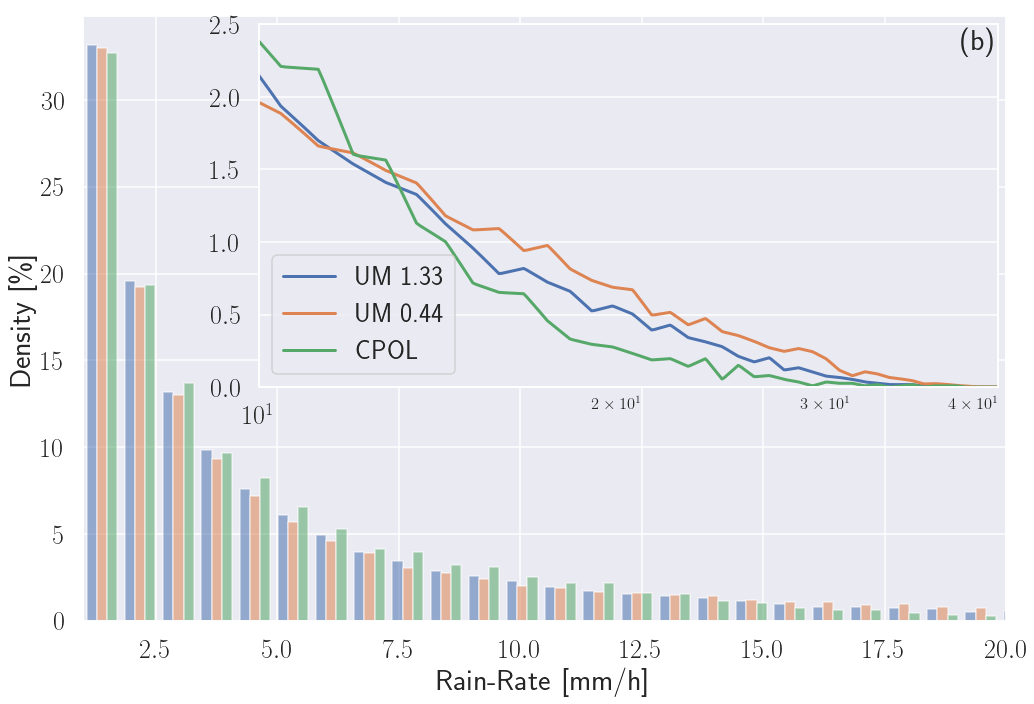

In [244]:
#Plot the pdfs
sns.set_style('darkgrid')
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid.inset_locator import inset_axes
dist=lognorm([LogNorm.CPOL['shape']*3.4], loc = np.log(LogNorm.CPOL['scale']*1.9))#, shape  # mu, sigma
med = np.median(um044vec.loc[um044vec>0].values)
X = np.linspace(0,65,200)
#b = 2.5
nbins = 100
def fitpdf(x, b):
    a=med*100
    return ((b/a) * (x/a)**(b-1)) / (1+(x/a)**b)**2
popt, pcov = PowerFit.CPOL['popt']/4, PowerFit.CPOL['pcov']
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
#Define histogram data to plot
formatter = FuncFormatter(lambda y, pos: r'$%i$'%int(100*y))

histdata = (um044vec.loc[um044vec>1], um133vec.loc[um133vec>1], obs_vec.loc[obs_vec>1])
n1, bins1, patches1 = ax.hist(histdata, bins=nbins, normed=1, alpha=0.55)
ax.tick_params(labelsize=fontsize-4)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlim(1.,20)
ax.set_ylabel('Density [\%]', fontsize=fontsize)
ax.set_xlabel('Rain-Rate [mm/h]', fontsize=fontsize)
dbin = (n1[1] - n1[0])/2.
f1 = interp1d(bins1[:-1]+dbin,  n1[0]+1e-6, kind='slinear')
f2 = interp1d(bins1[:-1]+dbin,  n1[1]+1e-6, kind='slinear')
f3 = interp1d(bins1[:-1]+dbin,  n1[2]+1e-6, kind='slinear')
newbins = np.linspace(1, 50, 500)

axin = inset_axes(ax, width = "80%", height = "60%", loc=1)
axin.plot(newbins,  f1(newbins)*100, label='UM 1.33',lw=3)
axin.plot(newbins,  f2(newbins)*100, label='UM 0.44',lw=3)
axin.plot(newbins,   f3(newbins)*100, label='CPOL',lw=3)
axin.set_xscale('log')

axin.tick_params(labelsize=fontsize-4)
axin.set_xlim(10, 42)
axin.set_ylim(1e-5, 2.5)

ann = axin.annotate("(b)", (0.95,0.93), xycoords="axes fraction", fontsize=fontsize)
axin.legend(loc=3, fontsize=fontsize-4)
fig.subplots_adjust(bottom=0.13, right=0.98, top=0.97)
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)
mpld3.disable_notebook()

In [166]:
np.histogram?

## 3.2 Percentiles
Now get the percentiles for the ensemble simulation and compare it against the observations

In [193]:
#Calculate the percentiles of the obs and sim for the considered week
percindex = pd.read_hdf(PercF, 'break')['10min'].index.values
OBS_perc = np.nanpercentile(np.ma.masked_less_equal(OBS.dataset[1].variables['lsrain'][:],.1).filled(np.nan), percindex)
UM133_perc = np.nanpercentile(np.ma.masked_less_equal(UM133ens.variables['lsrain'][:],.1).filled(np.nan), percindex)
UM044_perc = np.nanpercentile(np.ma.masked_less_equal(UM044ens.variables['lsrain'][:],.1).filled(np.nan), percindex)
PERC = pd.DataFrame({'Obs':OBS_perc, 'UM 1.33km':UM133_perc, 'UM 0.44km':UM044_perc}, index=percindex)

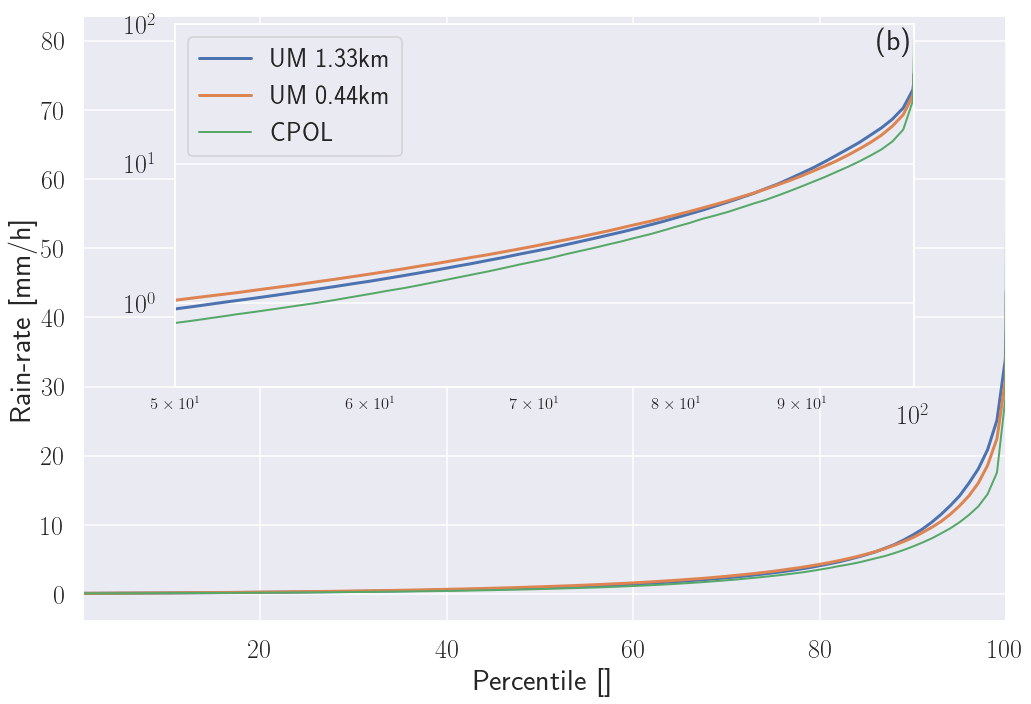

In [240]:
#Plot the percentages
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.05, right=0.9, top=0.4)

ax.plot(PERC.index, PERC['UM 1.33km'].values, label='UM 1.33km',lw=3)
ax.plot(PERC.index, PERC['UM 0.44km'].values, label='UM 0.44km', lw=3)
ax.plot(PERC.index, PERC['Obs'].values, label='CPOL',lw=2)
ax.set_xlim(1,100)
#ax.set_ylim(10,100)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Percentile []', fontsize=fontsize)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=fontsize)

ax.tick_params(labelsize=fontsize-4)
axin = inset_axes(ax, width = "80%", height = "60%", loc=9)

axin.plot(PERC.index[1:], PERC['UM 1.33km'].values[1:], label='UM 1.33km',lw=3)
axin.plot(PERC.index[1:], PERC['UM 0.44km'].values[1:], label='UM 0.44km', lw=3)
axin.plot(PERC.index[1:], PERC['Obs'].values[1:], label='CPOL',lw=2)
axin.tick_params(labelsize=fontsize-4)
axin.set_xlim(50, 100)
axin.set_ylim(.25,100)
axin.legend(loc=0, fontsize=fontsize-4)
ann = axin.annotate("(b)", (0.95,0.93), xycoords="axes fraction", fontsize=fontsize)
axin.set_yscale('log')
axin.set_xscale('log')
fig.subplots_adjust(bottom=0.13, right=0.98, top=0.97)
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

In [54]:
nplot

15

In [ ]:
mpl.ticker.ScalarFormatter?

# Z. Intermezzo (Comparison CPOL old vs new)

In [ ]:
##Intermezzo
first = True
fig = plt.figure()
fig.subplots_adjust(right=0.95, bottom=0.05, top=0.95,left=0.05, hspace=0, wspace=0)
data1 = np.ma.masked_less(OBS.dataset[-1].variables['lsrain'][:].values, 0.02)
data2 = np.ma.masked_less(OBS.dataset[1].variables['lsrain'][:].values, 0.02)
t1 = OBS.dataset[-1].variables['t'][:]
t2 = OBS.dataset[1].variables['t'][:]
tsteps = pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone).to_pydatetime()
#for tt, tstep in enumerate(tsteps):
tt = 0
fname = os.path.join(outdir, 'Comparison_%05i.png'%tt)
#sys.stdout.flush()
#sys.stdout.write('\r Creating %s ....    '%os.path.basename(fname))
#sys.stdout.flush()
lon1, lat1 = OBS.dataset[-1].variables['longitude'][0,:], OBS.dataset[-1].variables['latitude'][:,0]
lon2, lat2 = OBS.dataset[1].variables['longitude'][0,:], OBS.dataset[1].variables['latitude'][:,0]
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
m1 = Basemap(llcrnrlat=min(lat1), llcrnrlon=min(lon1), urcrnrlat=max(lat1), urcrnrlon=max(lon1), resolution='i',
            area_thresh=1, ax=ax1)
m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2), resolution='i',
            area_thresh=1, ax=ax2)
im1 = m1.pcolormesh(lon1, lat1, data1[tt].filled(-1),vmin=0.0,vmax=30,cmap='Blues')
im2 = m2.pcolormesh(lon2, lat2, data2[tt].filled(-1),vmin=0.0,vmax=30,cmap='Blues')
m1.drawcoastlines()
m2.drawcoastlines()
cbar_ax = fig.add_axes([0.14, 0.35, 0.74, 0.01])
cbar=fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Rain-rate [mm/h]',size=24)
ax2.set_title('Old CPOL version at %s LT' %tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
ax1.set_title('New CPOL version at %s LT'%tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
def ani(tt):
    im1.set_array((data1[tt]).filled(-1).ravel())
    im2.set_array((data2[tt]).filled(-1).ravel())
    ax2.set_title('Old CPOL version at %s LT' %tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
    ax1.set_title('New CPOL version at %s LT'%tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
    return(im1, im2)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, ani, frames=100, interval=20, blit=True)
#fig.savefig(fname, bbox_inches='tight', format='png', dpi=72)
#break
#sys.stdout.write('\n')

In [ ]:
#Visualize intermezzo
import io
import base64
from IPython.display import HTML
viddir = os.path.join(os.getenv('HOME'),'Data/Extremes/CPOL/Plot/Versions')
outvid=os.path.join(viddir,'WeekOfHector.mp4')
video = io.open(outvid, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="950" height="500" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### 2.1 Distribution of Percentiles during break and bursts

Now we compare the distributions of percentiles during break and burst periods. We also add 

In [ ]:
#Plot percentiles for breaks, bursts and all
colors = {'10min':'firebrick'}# '1h':'lightseagreen', '3h':'fuchsia' , '6h':'cornflowerblue'}
fig=plt.figure()
ax = fig.add_subplot(111)
for con in (('break','-'), ('burst','--'), ('all','-.')):
    for gr in colors.keys():        
        df = pd.read_hdf(PercF, con[0])[gr]
        ax.plot(df.index, df.values, color=colors[gr], linestyle=con[-1], label='%s (%s)'%(gr, con[0]))
ax.set_xlim(1,99.9999)
#ax.set_ylim(0.11,)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Percentile [%]', fontsize=26)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=26)
ax.legend(loc=0, fontsize=24)
ax.tick_params(labelsize=24)